In [17]:
!pip install diffusers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 10.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 19.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.6/301.6 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.0
    Uninstalling fsspec-2024.6.0:
      Successfully uninstalled fsspec-2024.6.0


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
diffusion_pytorch_model.safetensors not found
Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]/root/miniconda3/envs/llm/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
100%|██████████| 1000/1000 [00:20<00:00, 49.82it/s]


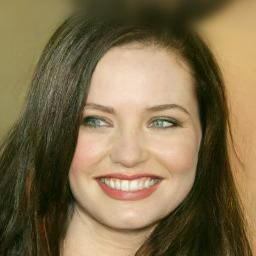

In [5]:
import torch
from diffusers import DDPMPipeline

# We can set the device to either use our GPU or use our CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the pipeline
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

# Sample an image
image_pipe().images[0]

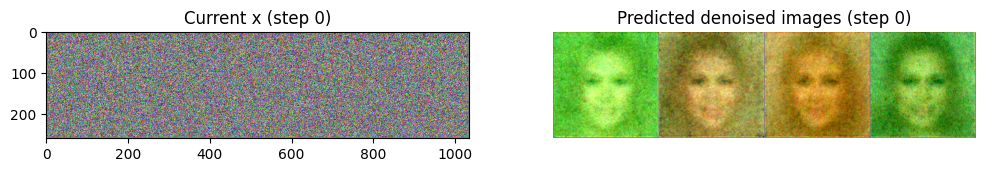

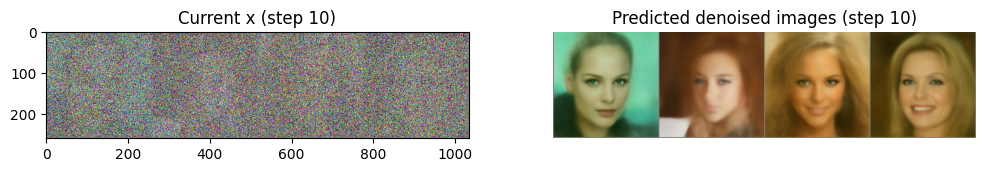

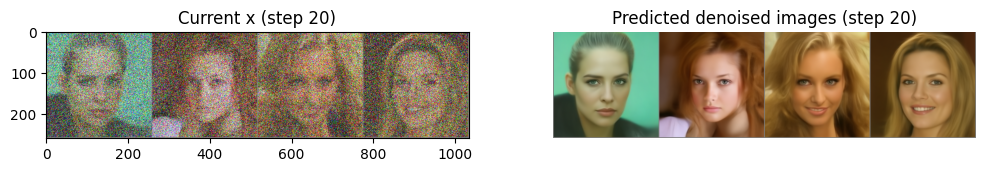

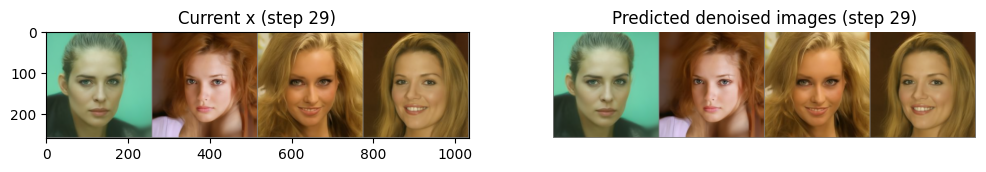

In [18]:
from utils.utils import plot_noise_and_denoise

# The random starting point is a batch of 4 images
# Each image is 3-channel (RGB) 256x256 pixel image
image = torch.randn(4, 3, 256, 256).to(device)

# Set the specific number of diffusion steps
image_pipe.scheduler.set_timesteps(num_inference_steps=30)

# Loop through the sampling timesteps
for i, t in enumerate(image_pipe.scheduler.timesteps):
    # Get the prediction given the current sample x and the timestep t
    # As we're running inference, we don't need to calculate gradients,
    # so we can use torch.no_grad().
    with torch.no_grad():
        # We need to pass in the timestep t so that the model knows what
        # timestep it's currently at. We'll learn more about this in the
        # coming sections.
        noise_pred = image_pipe.unet(image, t)["sample"]

    # Calculate what the updated x should look like with the scheduler
    scheduler_output = image_pipe.scheduler.step(noise_pred, t, image)

    # Update x
    image = scheduler_output.prev_sample

    # Occasionally display both x and the predicted denoised images
    if i % 10 == 0 or i == len(image_pipe.scheduler.timesteps) - 1:
        plot_noise_and_denoise(scheduler_output, i)

In [19]:
from datasets import load_dataset

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

Repo card metadata block was not found. Setting CardData to empty.
Generating train split: 100%|██████████| 1000/1000 [00:00<00:00, 4500.15 examples/s]


In [20]:
from torchvision import transforms

image_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

In [21]:
# We'll load a batch of 16 images at a time.
batch_size = 16


def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

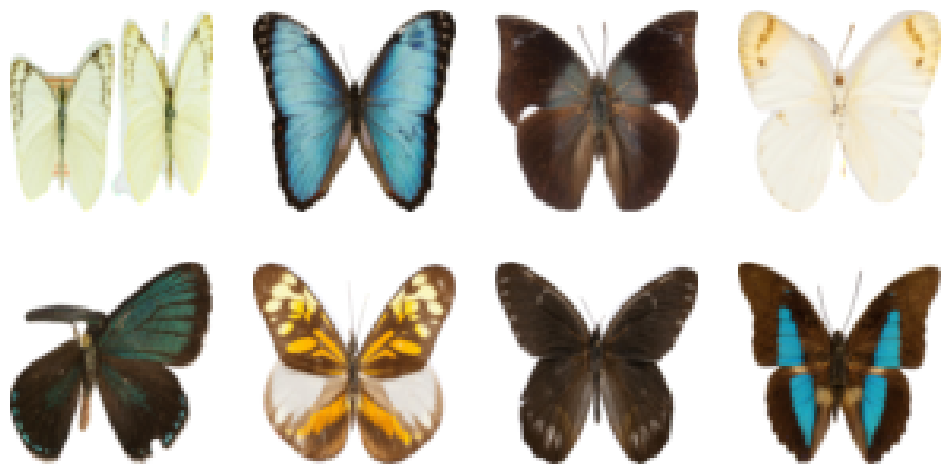

In [22]:
from utils.utils import show_images

batch = next(iter(train_dataloader))

# When we normalized, we mapped (0, 1) to (-1, 1)
# Now we map back to (0, 1) for display
show_images(batch["images"][:8] * 0.5 + 0.5)

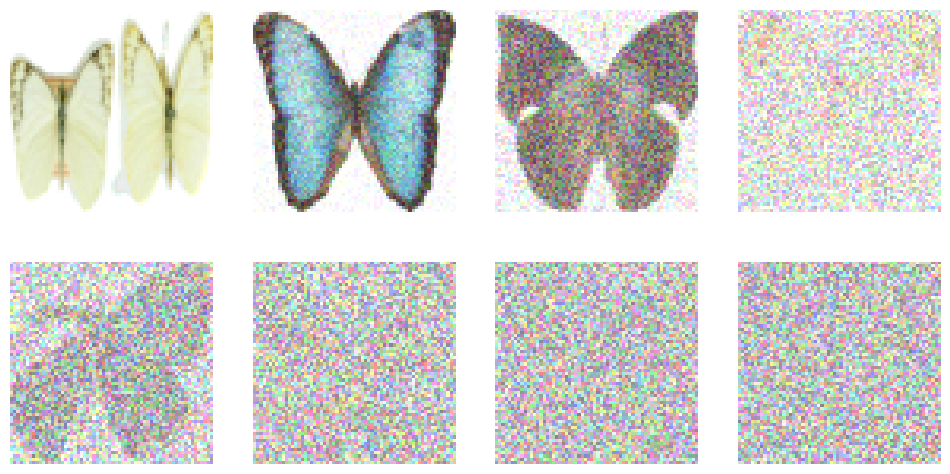

In [33]:
from diffusers import DDPMScheduler

# We'll learn about beta_start and beta_end in the next sections
scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.02
)
timesteps = torch.linspace(0, 999, 8).long()

# We load 8 images from the dataset and
# add increasing amounts of noise to them
x = batch["images"][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x * 0.5 + 0.5).clip(0, 1))

In [34]:
from diffusers import UNet2DModel

# Create a UNet2DModel
model = UNet2DModel(
    in_channels=3,  # 3 channels for RGB images
    sample_size=64,  # Specify our input size
    # The number of channels per block affects the model size
    block_out_channels=(64, 128, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)

# Pass a batch of data through to see it works
with torch.no_grad():
    out = model(noised_x.to(device), timestep=timesteps.to(device)).sample

print(noised_x.shape)
print(out.shape)

torch.Size([8, 3, 64, 64])
torch.Size([8, 3, 64, 64])


In [35]:
from torch.nn import functional as F

num_epochs = 50  # How many runs through the data should we do?
lr = 1e-4  # What learning rate should we use
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
losses = []  # Somewhere to store the loss values for later plotting

# Train the model (this takes a while!)
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Load the input images
        clean_images = batch["images"].to(device)

        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(device)

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (clean_images.shape[0],),
            device=device,
        ).long()

        # Add noise to the clean images according
        # to the noise magnitude at each timestep
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        # The model also uses the timestep as an input
        # for additional conditioning
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise
        loss = F.mse_loss(noise_pred, noise)

        # Store the loss for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)
        optimizer.step()
        optimizer.zero_grad()

Text(0.5, 0, 'Training step')

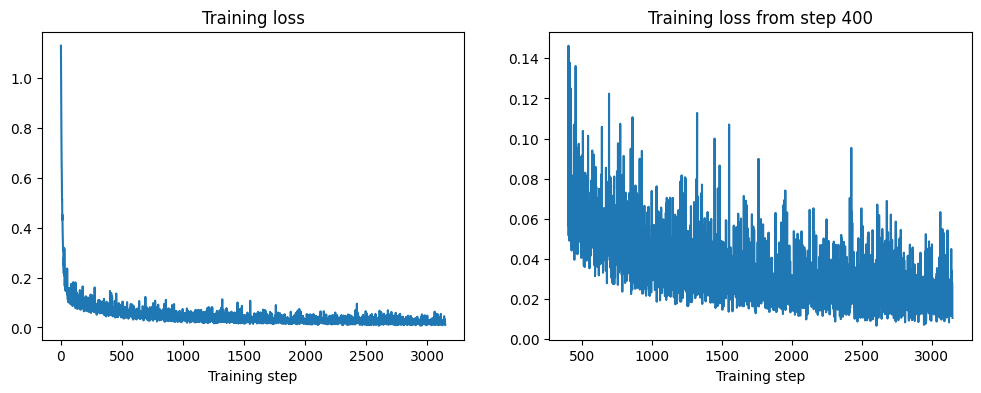

In [36]:
from matplotlib import pyplot as plt

plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Training step")

plt.subplot(1, 2, 2)
plt.plot(range(400, len(losses)), losses[400:])
plt.title("Training loss from step 400")
plt.xlabel("Training step")

100%|██████████| 1000/1000 [00:10<00:00, 93.18it/s]


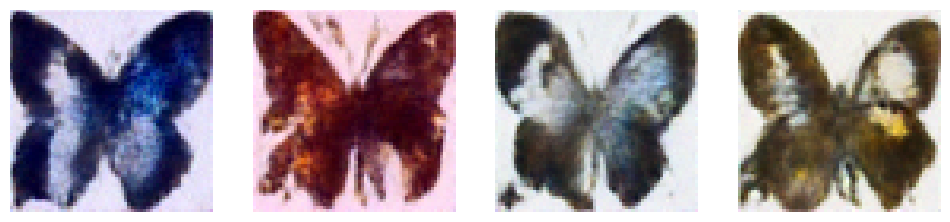

In [37]:
pipeline = DDPMPipeline(unet=model, scheduler=scheduler)
ims = pipeline(batch_size=4).images
show_images(ims, nrows=1)

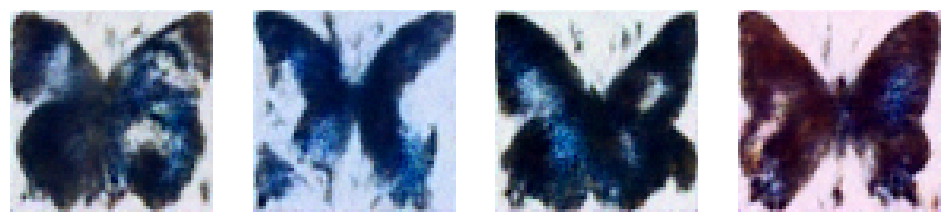

In [38]:
# Random starting point (4 random images):
sample = torch.randn(4, 3, 64, 64).to(device)

for t in scheduler.timesteps:
    # Get the model prediction
    with torch.no_grad():
        noise_pred = model(sample, t)["sample"]

    # Update sample with step
    sample = scheduler.step(noise_pred, t, sample).prev_sample

show_images(sample.clip(-1, 1) * 0.5 + 0.5, nrows=1)

In [39]:
x = next(iter(train_dataloader))["images"][:8]
noise = torch.rand_like(x)

In [40]:
def corrupt(x, noise, amount):
    amount = amount.view(-1, 1, 1, 1)  # make sure it's broadcastable
    return (
        x * (1 - amount) + noise * amount
    )  # equivalent to x.lerp(noise, amount)

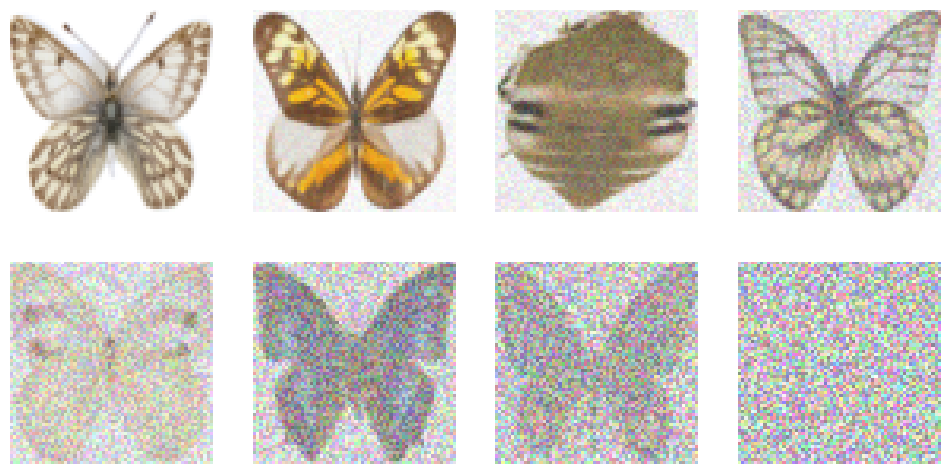

In [41]:
amount = torch.linspace(0, 1, 8)
noised_x = corrupt(x, noise, amount)
show_images(noised_x * 0.5 + 0.5)

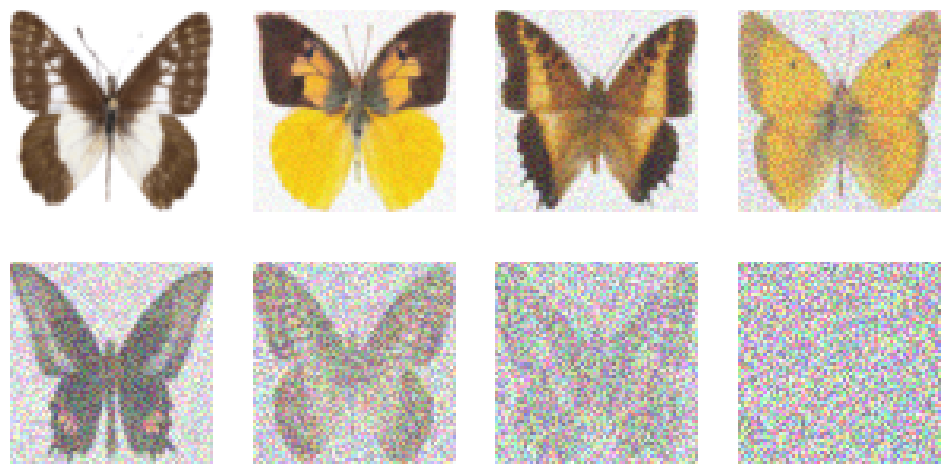

In [26]:
class SimpleScheduler:
    def __init__(self):
        self.num_train_timesteps = 1000

    def add_noise(self, x, noise, timesteps):
        amount = timesteps / self.num_train_timesteps
        return corrupt(x, noise, amount)


scheduler = SimpleScheduler()
timesteps = torch.linspace(0, 999, 8).long()
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images(noised_x * 0.5 + 0.5)

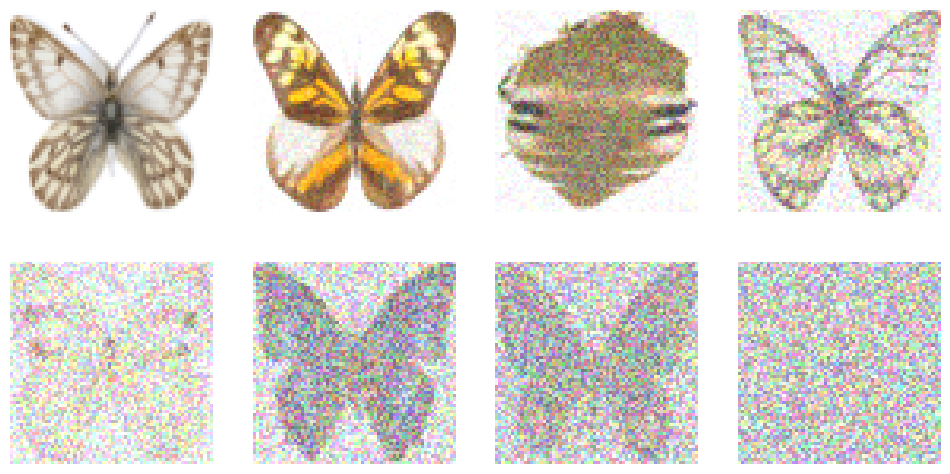

In [42]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(beta_end=0.01)
timesteps = torch.linspace(0, 999, 8).long()
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x * 0.5 + 0.5).clip(0, 1))

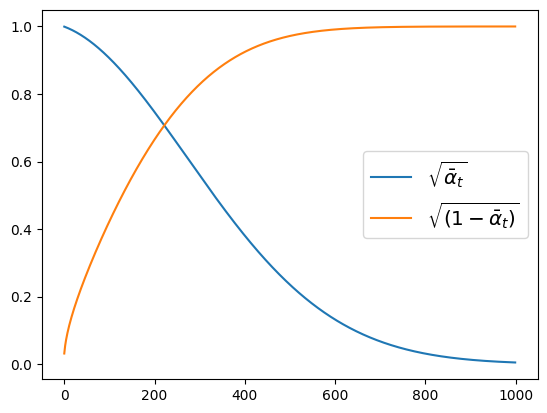

In [43]:
from utils.utils import plot_scheduler

plot_scheduler(
    DDPMScheduler(beta_start=0.001, beta_end=0.02, beta_schedule="linear")
)

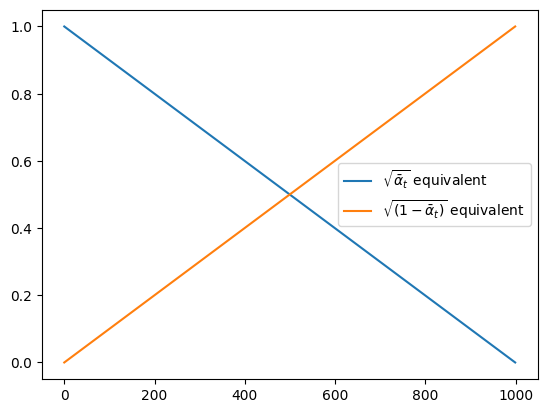

In [44]:
plot_scheduler(SimpleScheduler())

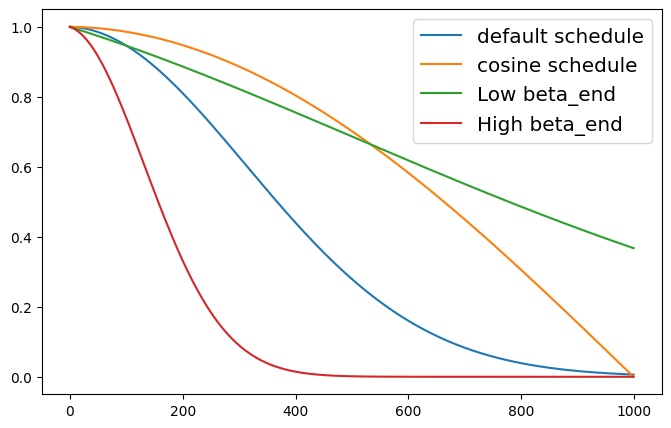

In [45]:
fig, (ax) = plt.subplots(1, 1, figsize=(8, 5))
plot_scheduler(
    DDPMScheduler(beta_schedule="linear"),
    label="default schedule",
    ax=ax,
    plot_both=False,
)
plot_scheduler(
    DDPMScheduler(beta_schedule="squaredcos_cap_v2"),
    label="cosine schedule",
    ax=ax,
    plot_both=False,
)
plot_scheduler(
    DDPMScheduler(beta_start=0.001, beta_end=0.003, beta_schedule="linear"),
    label="Low beta_end",
    ax=ax,
    plot_both=False,
)
plot_scheduler(
    DDPMScheduler(beta_start=0.001, beta_end=0.1, beta_schedule="linear"),
    label="High beta_end",
    ax=ax,
    plot_both=False,
)

In [32]:
from torch import nn


class BasicUNet(nn.Module):
    """A minimal UNet implementation."""

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )

        # Use the SiLU activation function, which has been shown to work well
        # due to different properties (smoothness, non-monotonicity, etc.).
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:  # For all but the third (final) down layer:
                h.append(x)  # Storing output for skip connection
                x = self.downscale(x)  # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upscale
                x += h.pop()  # Fetching stored output (skip connection)
            x = self.act(l(x))

        return x